In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from sklearn.utils import shuffle
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC

from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.models import load_model

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, ZeroPadding2D, GlobalAveragePooling2D, Activation, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle-2.json ~/.kaggle/

In [5]:
!kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 90% 133M/149M [00:00<00:00, 161MB/s]
100% 149M/149M [00:00<00:00, 169MB/s]


In [6]:
import zipfile
zip = zipfile.ZipFile('/content/brain-tumor-mri-dataset.zip', 'r')
zip.extractall("/content")
zip.close()

In [12]:
train_dir = '/content/Training'
test_dir = '/content/Testing'

In [13]:
from tensorflow import keras
train_ds_vgg = keras.utils.image_dataset_from_directory(directory = train_dir,
                                                   labels = 'inferred',
                                                   label_mode = 'int',
                                                   batch_size = 32,
                                                   image_size = (224,224))

validation_ds_vgg = keras.utils.image_dataset_from_directory(directory = test_dir,
                                                   labels = 'inferred',
                                                   label_mode = 'int',
                                                   batch_size = 32,
                                                   image_size = (224,224))

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [16]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

def preprocess_vgg16(image, label):   # To preprocess the pixel values
    image = preprocess_input(image)

    return image, label

train_ds_vgg.map(preprocess_vgg16)
validation_ds_vgg.map(preprocess_vgg16)

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [17]:
conv_base_vgg = VGG16(include_top=False,
                  weights = 'imagenet',
                  input_shape=(224,224,3))

conv_base_vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
for layer in conv_base_vgg.layers:
    print(layer.name)

input_layer
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [20]:
conv_base_vgg.trainable = False
set_trainable = False

for layer in conv_base_vgg.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True

    if set_trainable:
        layer.trainable = True

    else:
        layer.trainable = False

for layer in conv_base_vgg.layers:
    print(layer.name, layer.trainable)

input_layer False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [21]:
import tensorflow as tf

from tensorflow.keras.models import Model

# Creating a new model and adding fully connected layers
x = conv_base_vgg.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax', name='fc1000')(x)

model = Model(inputs=conv_base_vgg.input, outputs=x)

In [22]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,139,524 (80.64 MB)

 Trainable params: 13,503,748 (51.51 MB)

 Non-trainable params: 7,635,776 (29.13 MB)

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import os

local_save_path = '/content/BEST_vgg16_pretrained2.keras'

os.makedirs(os.path.dirname(local_save_path), exist_ok=True)

checkpoint = ModelCheckpoint(filepath=local_save_path,
                              monitor='val_loss',
                              save_best_only=True,
                              save_weights_only=False,
                              verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                          factor=0.1,
                                          patience=6,
                                          verbose=1)

early_stopping = EarlyStopping(monitor='val_accuracy',
                               verbose=1,
                               patience=10)

callbacks = [checkpoint, reduce_learning_rate, early_stopping]

In [25]:
from tensorflow.keras.optimizers import Adam, RMSprop

model.compile(optimizer=RMSprop(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
history = model.fit(train_ds, epochs=10,
                    batch_size=32,
                    validation_data = validation_ds,
                    verbose=1,
                    callbacks = callbacks)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.5932 - loss: 1.2045
Epoch 1: val_loss improved from inf to 0.67360, saving model to /content/BEST_vgg16_pretrained2.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 72s 311ms/step - accuracy: 0.5940 - loss: 1.2023 - val_accuracy: 0.7979 - val_loss: 0.6736 - learning_rate: 1.0000e-05
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8701 - loss: 0.4064
Epoch 2: val_loss improved from 0.67360 to 0.30475, saving model to /content/BEST_vgg16_pretrained2.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 43s 177ms/step - accuracy: 0.8702 - loss: 0.4060 - val_accuracy: 0.8978 - val_loss: 0.3047 - learning_rate: 1.0000e-05
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9211 - loss: 0.2253
Epoch 3: val_loss improved from 0.30475 to 0.20946, saving model to /content/BEST_vgg16_pretrained2.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 32s 180ms/step - accuracy: 0.9212 - loss: 0.2252 - val_accuracy: 0.9260 - val_loss: 0.2095 - lear

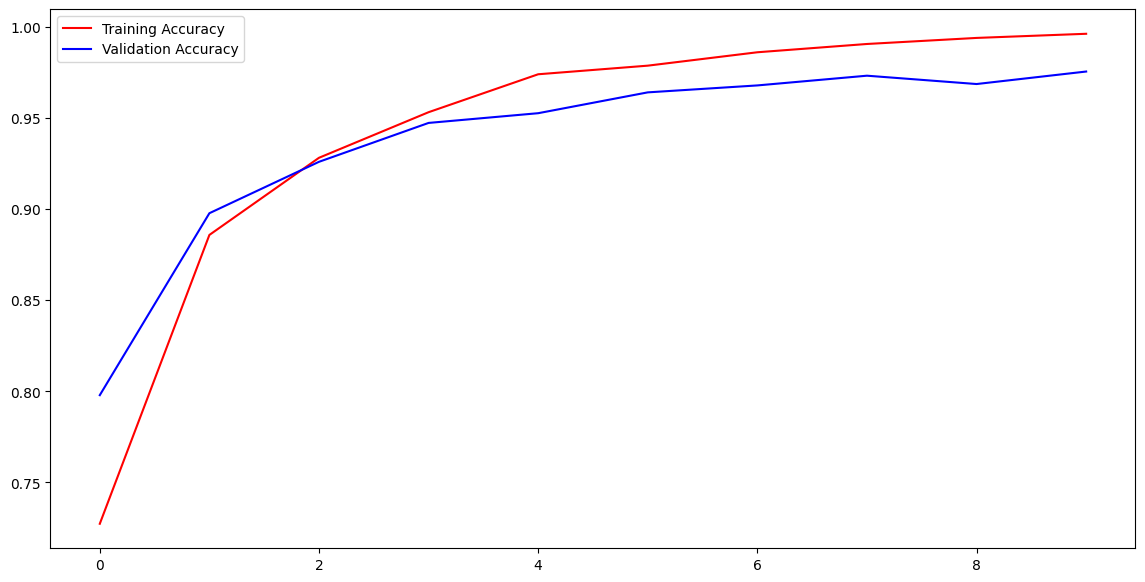

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.legend(loc='upper left')
plt.show()

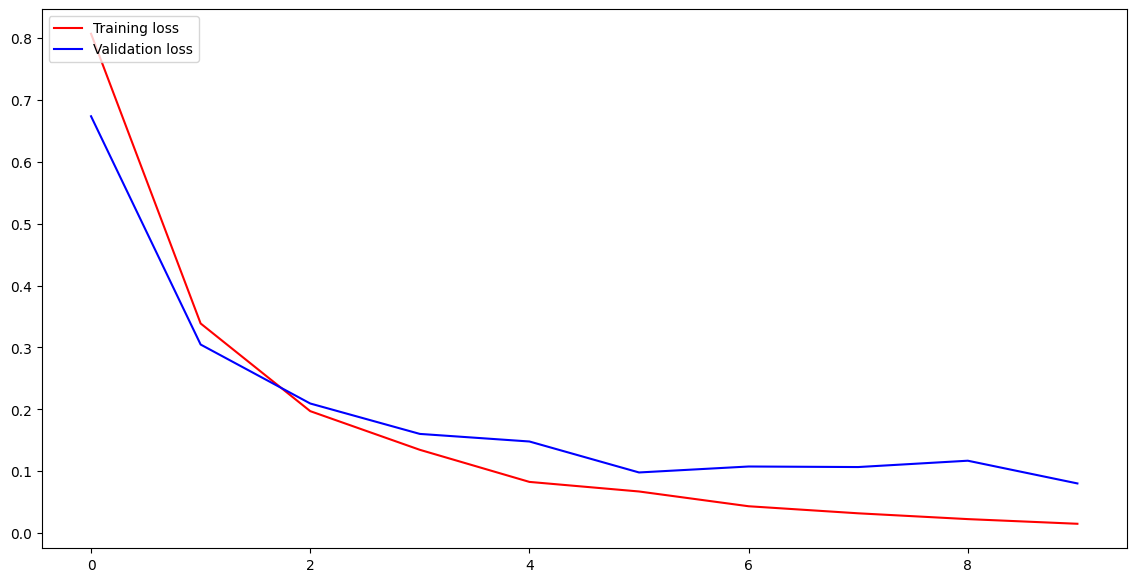

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.legend(loc='upper left')
plt.show()

In [34]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

model = load_model('/content/BEST_vgg16_pretrained2.keras')

predict_list = []
true_labels = []

for batch in validation_ds_vgg:

    images, labels = batch
    true_labels.extend(labels.numpy())

    for img in images:
        img_array = np.array(img)
        img_array = img_array.reshape(1, 224, 224, 3)

        pred = model.predict(img_array)

        indices = pred.argmax()

        predict_list.append(indices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

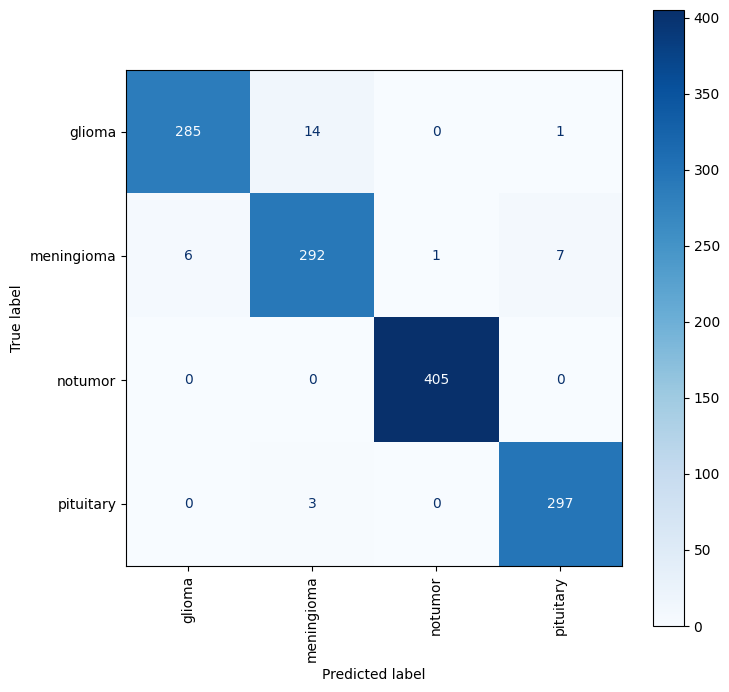

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
cm = confusion_matrix(true_labels, predict_list)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.show()

In [37]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predict_list))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       300
           1       0.94      0.95      0.95       306
           2       1.00      1.00      1.00       405
           3       0.97      0.99      0.98       300

    accuracy                           0.98      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.98      0.98      0.98      1311

